In [1]:
import json
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats
from copy import deepcopy
from pymongo import MongoClient
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from packaging.version import Version
from cliffs_delta import cliffs_delta
from scipy.stats import mannwhitneyu
from multipy.fwer import holm_bonferroni

%matplotlib inline
%config InlineBackend.figure_format = "retina"
pd.set_option("display.max_rows", None)

In [2]:
pypi_db = MongoClient(host='127.0.0.1', port=27017)['pypi']
dl_packages = pypi_db['dl_packages']
distribution_metadata = pypi_db['distribution_metadata']
frameworks = {
    "tensorflow": ['tensorflow', 'tensorflow-cpu', 'tensorflow-gpu'],
    "pytorch": ['torch'],
    "mxnet": ['mxnet', 'mxnet-cu112', 'mxnet-cu110', 'mxnet-cu102', 'mxnet-cu102mkl', 'mxnet-cu101', 'mxnet-cu101mkl', 
              'mxnet-cu100', 'mxnet-cu100mkl', 'mxnet-cu92', 'mxnet-cu92mkl', 'mxnet-cu90', 'mxnet-cu90mkl', 
              'mxnet-cu80', 'mxnet-cu80mkl', 'mxnet-native'],
    "paddlepaddle": ['paddlepaddle', 'paddlepaddle-gpu'],
    "mindspore": ['mindspore', 'mindspore-ascend', 'mindspore-gpu']
}
pkg_layers = pd.read_csv("data/package_statistics.csv")
edges = pd.read_csv("data/dag.edgs")
gh_dependents = json.load(open("data/pkg_github_dependents.json"))
woc_dependents = json.load(open("data/pkg_woc_dependents.json"))
pkg_layers.head()

,package,import_name,layer,framework,down_pkgs,gh_downstream,woc_downstream,comb_downstream
0,facex,facex,2,tensorflow,0,0,1,1
1,tf-semantic-segmentation,tf_semantic_segmentation,2,tensorflow,0,0,1,1
2,tf-semantic-segmentation,tf_semantic_segmentation,3,tensorflow,0,0,1,1
3,tbnns,tbnns,2,tensorflow,0,0,2,2
4,tfaip,tfaip,3,tensorflow,1,9,3,10


In [3]:
def layer_count():
    layer_count = pkg_layers.groupby(['layer', 'framework'])[
        'package'].count().unstack().fillna(0)
    layer_count.loc['sum', :] = pkg_layers[['framework', 'package']
                                        ].drop_duplicates().groupby('framework')['package'].count()
    layer_count = layer_count.astype(int)
    layer_count = layer_count[frameworks]
    return layer_count
layer_count()

framework,tensorflow,pytorch,mxnet,paddlepaddle,mindspore
layer,,,,,
2,2218,2779,57,30,3
3,677,1809,17,6,0
4,82,105,0,0,0
5,11,12,0,0,0
6,1,0,0,0,0
sum,2565,3277,71,31,3


## Lead Packages

In [4]:
def construct_dag(framework: str) -> nx.DiGraph:
    g = nx.DiGraph()
    tmp_df = edges[edges.framework == framework]
    orphans = pkg_layers[(pkg_layers.framework == framework) & (pkg_layers.layer == 2) & 
                         (pkg_layers.down_pkgs == 0)]['package'].values
    l1 = frameworks[framework]
    for row in tmp_df.iterrows():
        to_node, from_node = row[1][:2]
        if (from_node in l1) or (to_node in l1):
            continue
        else:
            g.add_edge(from_node, to_node)
    print(f'{framework}: {len(g.nodes)} nodes, {len(g.edges)} edges')
    return g

tfg = construct_dag('tensorflow')
ptg = construct_dag('pytorch')
mng = construct_dag('mxnet')
ppg = construct_dag('paddlepaddle')
msg = construct_dag('mindspore')

tensorflow: 894 nodes, 938 edges
pytorch: 2045 nodes, 2662 edges
mxnet: 24 nodes, 17 edges
paddlepaddle: 8 nodes, 6 edges
mindspore: 0 nodes, 0 edges


In [5]:
def greedy_coverage(g: nx.DiGraph, k: int, framework: str, *, ratio=None):
    tmp_g = deepcopy(g)
    nodes = len(list(g.nodes))
    
    def find_max(tg):
        m, nd = 0, None
        for n in tg.nodes:
            if len(nx.descendants(tmp_g, n)) > m:
                m = len(nx.descendants(tmp_g, n))
                nd = n
        return m, nd
    _, nd = find_max(tmp_g)
    if nd is None:
        print(f'{framework}: 0 packages cover 0 of {nodes} packages')
        return []
    res = [nd]
    cov = [nd]
    cov.extend(nx.descendants(g, nd))
    if ratio and (len(set(cov)) >= nodes * ratio):
        print(f'{framework}: {len(res)} packages cover {len(set(cov))} of {nodes} packages')
        return res
    k -= 1
    while k > 0:
        k -= 1
        tmp_g.remove_nodes_from(nx.descendants(tmp_g, nd))
        _, nd = find_max(tmp_g)
        if nd is None:
            print(f'{framework}: {len(res)} packages cover {len(set(cov))} of {nodes} packages')
            return res, len(set(cov))
        cov.append(nd)
        cov.extend(nx.descendants(g, nd))
        res.append(nd)
        if ratio and (len(set(cov)) >= nodes * ratio):
            print(f'{framework}: {len(res)} packages cover {len(set(cov))} of {nodes} packages')
            return res
    print(f'{framework}: {len(res)} packages cover {len(set(cov))} of {nodes} packages')
    return res

In [6]:
greedy_coverage(tfg, 160, 'tensorflow', ratio=0.8)
print('Top 11 packages:', greedy_coverage(tfg, 11, 'tensorflow', ratio=0.8))
print(greedy_coverage(ptg, 120, 'pytorch', ratio=0.8))
print(greedy_coverage(mng, 40, 'mxnet', ratio=0.8))
print(greedy_coverage(ppg, 40, 'paddlepaddle', ratio=0.8))
print(greedy_coverage(msg, 40, 'mindspore', ratio=0.8))

tensorflow: 63 packages cover 716 of 894 packages
tensorflow: 11 packages cover 501 of 894 packages
Top 11 packages: ['Keras', 'tensorflow-addons', 'streamlit', 'tensorflow-probability', 'tensorflow-text', 'tensorflow-serving-api', 'keras2onnx', 'gpflow', 'keras-tuner', 'bert-for-tf2', 'g2p-en']
pytorch: 11 packages cover 1640 of 2045 packages
['torchvision', 'torchmetrics', 'torchtext', 'stanza', 'pytorch-pretrained-bert', 'torchaudio', 'pyro-ppl', 'pytorch-ignite', 'gpytorch', 'kornia', 'pytorch-transformers']
mxnet: 5 packages cover 20 of 24 packages
['tensorly', 'cnocr', 'datawig', 'onnx-mxnet', 'gluonts']
paddlepaddle: 2 packages cover 8 of 8 packages
['sabhi-utils', 'paddle-serving-client']
mindspore: 0 packages cover 0 of 0 packages
[]


In [7]:
def transitive_influence(g: nx.DiGraph):
    res = dict()
    for node in list(g.nodes):
        if g.out_degree(node) == 0:
            res[node] = 0
        else:
            res[node] = len(nx.descendants(g, node)) / g.out_degree(node)
    res = sorted(res.items(), key=lambda x: x[1], reverse=True)
    return pd.DataFrame(res, columns=['package', 'transitive_influence'])

## Popular Packages

In [8]:
(len(pkg_layers[(pkg_layers['gh_downstream'] == 0)]['package'].unique()),  # 80%
 len(pkg_layers[(pkg_layers['woc_downstream'] == 0)]['package'].unique()), # 49%
 len(pkg_layers[(pkg_layers['comb_downstream'] == 1)]['package'].unique()), # 45%
 len(pkg_layers['package'].unique()),
 len(pkg_layers[(pkg_layers['down_pkgs'] > 5)]['package'].unique()))

(4433, 2713, 816, 5572, 75)

In [9]:
tf_layers = pkg_layers[pkg_layers.framework == 'tensorflow'][['package', 'down_pkgs', 'comb_downstream']].drop_duplicates()
pt_layers = pkg_layers[pkg_layers.framework == 'pytorch'][['package', 'down_pkgs', 'comb_downstream']].drop_duplicates()
print(len(tf_layers), len(pt_layers))
print(np.mean(tf_layers['down_pkgs']), np.mean(pt_layers['down_pkgs']), np.mean(tf_layers['comb_downstream']), np.mean(pt_layers['comb_downstream']))
print(np.quantile(tf_layers['down_pkgs'], [0.9, 0.95, 0.99]), np.quantile(pt_layers['down_pkgs'], [0.9, 0.95, 0.99]))
print(np.quantile(tf_layers['comb_downstream'], [0.9, 0.95, 0.99]), np.quantile(pt_layers['comb_downstream'], [0.9, 0.95, 0.99]))
U1, p1 = stats.mannwhitneyu(tf_layers['down_pkgs'], pt_layers['down_pkgs'], alternative='less')
print(U1, p1)
U1, p2 = stats.mannwhitneyu(tf_layers['comb_downstream'], pt_layers['comb_downstream'], alternative='greater')
print(U1, p2)
print(holm_bonferroni([p1, p2]))
print(len(tf_layers[tf_layers.comb_downstream > 1000]) / len(tf_layers),
      len(pt_layers[pt_layers.comb_downstream > 1000]) / len(pt_layers),
      len(tf_layers[tf_layers.down_pkgs < 5]) / len(tf_layers),
      len(pt_layers[pt_layers.down_pkgs < 5]) / len(pt_layers),)

2565 3277
0.36608187134502923 0.8120231919438511 133.16842105263157 81.98840402807446
[1. 1. 6.] [1. 2. 7.]
[ 28.    92.6  825.44] [ 25.4  81.2 596.2]
4103429.5 0.0029114495690099338
4217043.0 0.4071044164081256
[ True False]
0.008576998050682261 0.006103143118706134 0.9859649122807017 0.9829111992676228


Effect size

```shell
> VD.A(d = tf$down_pkgs, f = pt$down_pkgs)

Vargha and Delaney A

A estimate: 0.493781 (negligible)

> VD.A(d = tf$comb_downstream, f = pt$comb_downstream)

Vargha and Delaney A

A estimate: 0.5061577 (negligible)

> cohen.d(d = tf$down_pkgs, f = pt$down_pkgs)

Cohen's d

d estimate: -0.02826614 (negligible)
95 percent confidence interval:
      lower       upper 
-0.07411942  0.01758713 

> cohen.d(d = tf$comb_downstream, f = pt$comb_downstream)

Cohen's d

d estimate: 0.01726816 (negligible)
95 percent confidence interval:
      lower       upper 
-0.02858375  0.06312007 

> cliff.delta(d = tf$down_pkgs, f = pt$down_pkgs)

Cliff's Delta

delta estimate: -0.01243803 (negligible)
95 percent confidence interval:
       lower        upper 
-0.027548603  0.002678235 

> cliff.delta(d = tf$comb_downstream, f = pt$comb_downstream)

Cliff's Delta

delta estimate: 0.01231537 (negligible)
95 percent confidence interval:
      lower       upper 
-0.01285416  0.03746929 
```

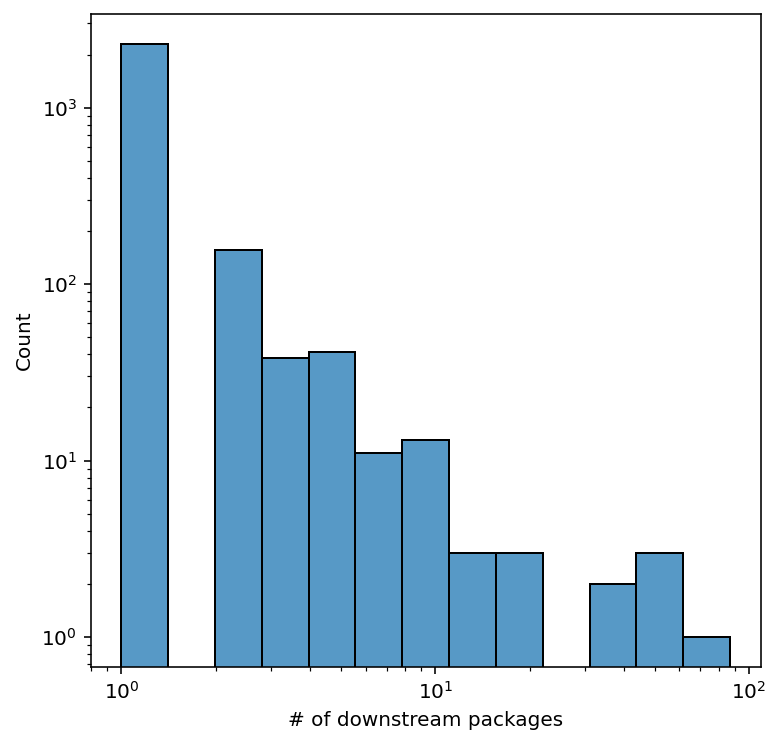

In [10]:
def test_histplot():
    f, ax = plt.subplots(figsize=(6, 6))
    ax.set(xscale="log", yscale="log")
    tmp = deepcopy(tf_layers)
    tmp['# of downstream packages'] = tmp['down_pkgs'] + 1
    sns.histplot(data=tmp, x='# of downstream packages', ax=ax)

test_histplot()

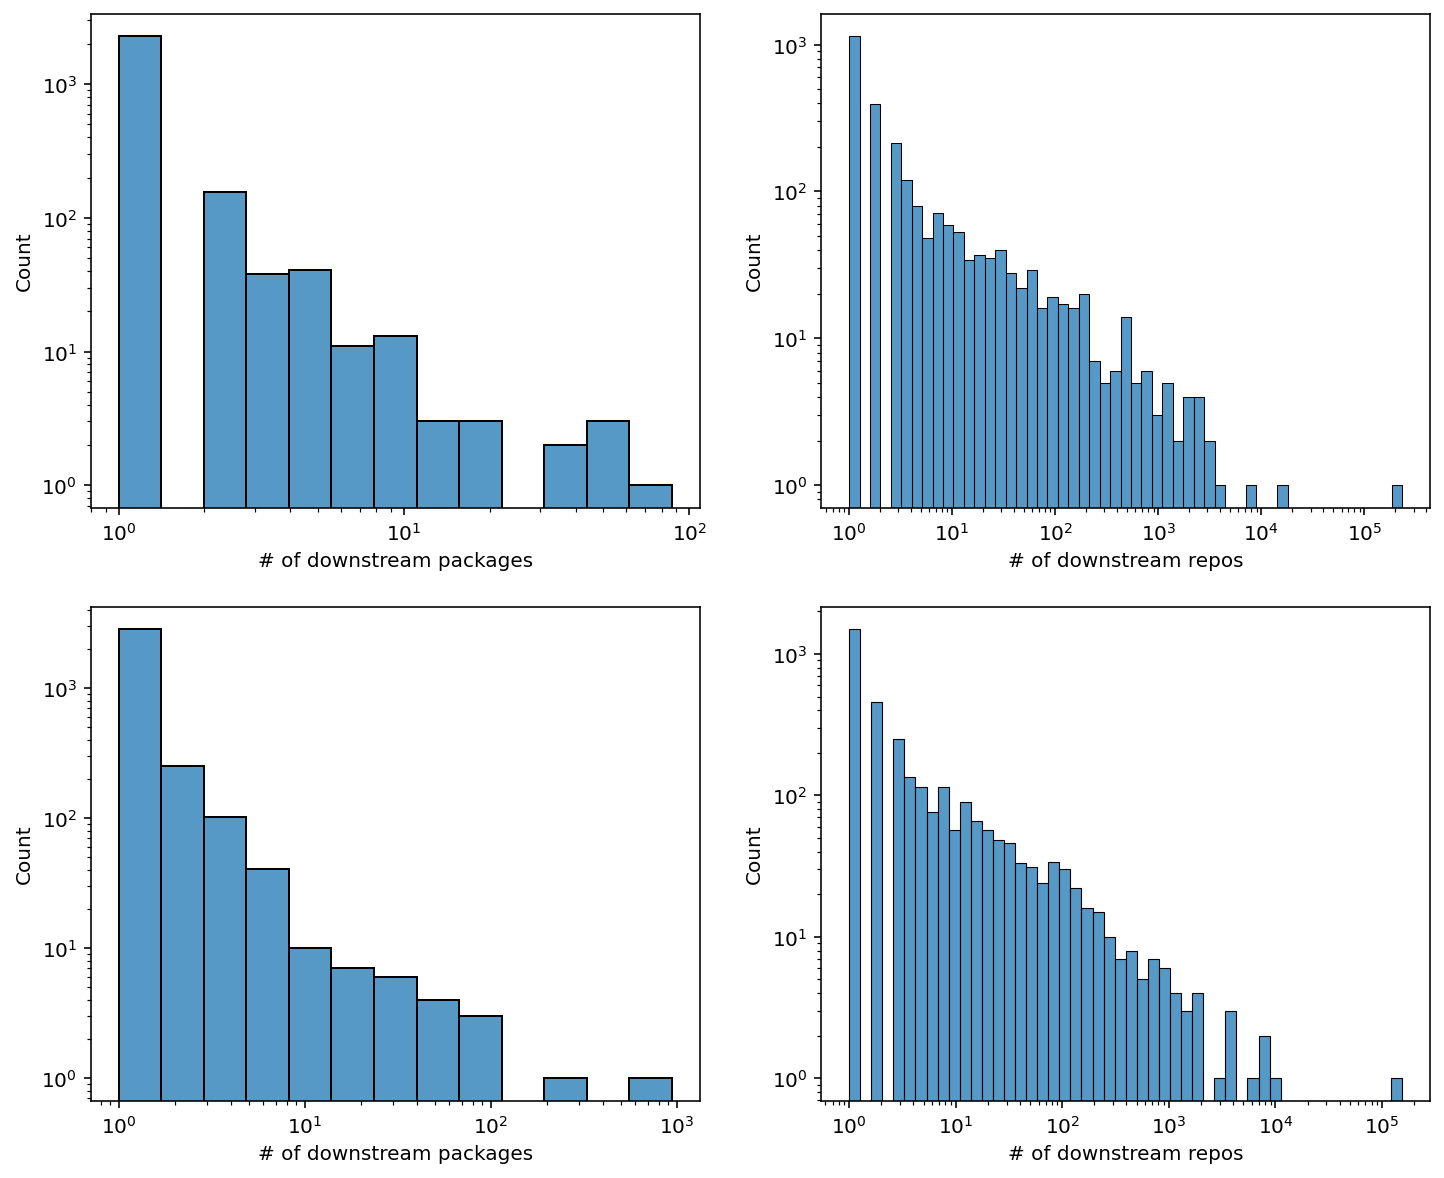

In [11]:
def my_histplot():
    f, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0][0].set(xscale="log", yscale="log")
    axes[0][1].set(xscale="log", yscale="log")
    axes[1][0].set(xscale="log", yscale="log")
    axes[1][1].set(xscale="log", yscale="log")
    tf_tmp = deepcopy(tf_layers)
    pt_tmp = deepcopy(pt_layers)
    tf_tmp['# of downstream packages'] = tf_tmp['down_pkgs'] + 1
    pt_tmp['# of downstream packages'] = pt_tmp['down_pkgs'] + 1
    tf_tmp['# of downstream repos'] = tf_tmp['comb_downstream'] + 1
    pt_tmp['# of downstream repos'] = pt_tmp['comb_downstream'] + 1
    sns.histplot(data=tf_tmp, x='# of downstream packages', ax=axes[0][0])
    sns.histplot(data=pt_tmp, x='# of downstream packages', ax=axes[1][0])
    sns.histplot(data=tf_tmp, x='# of downstream repos', ax=axes[0][1])
    sns.histplot(data=pt_tmp, x='# of downstream repos', ax=axes[1][1])

my_histplot()

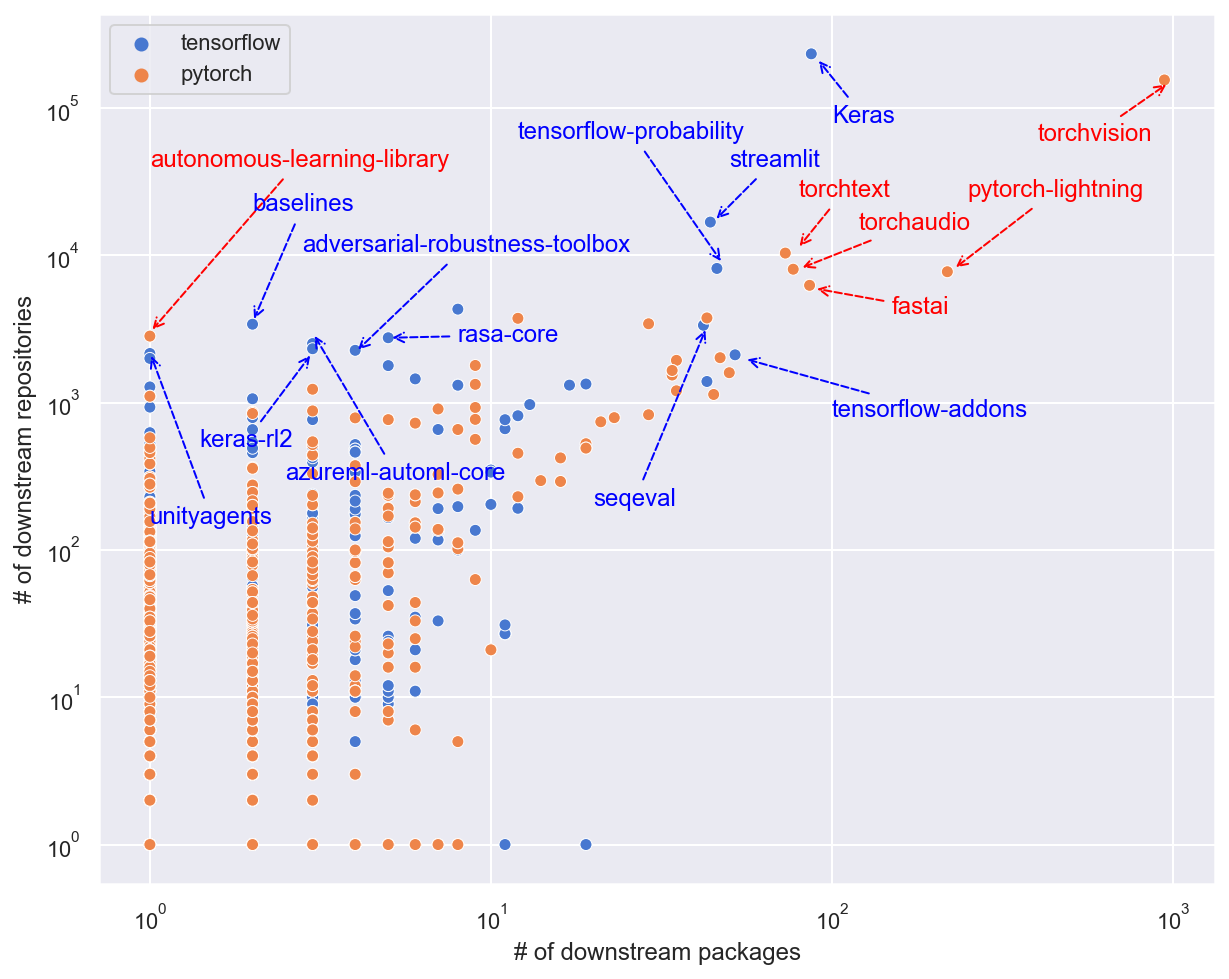

In [12]:
def plot_scatter():
    pkg_layers = pd.read_csv("data/package_statistics.csv")
    pkg_layers['down_pkgs'] = pkg_layers['down_pkgs'] + 1
    pkg_layers['comb_downstream'] = pkg_layers['comb_downstream'] + 1
    sns.set_theme(palette='muted')
    f, ax = plt.subplots(figsize=(10, 8))
    ax.set(xscale="log", yscale="log")
    tf_color = sns.color_palette(palette='muted')[0]
    pt_color = sns.color_palette(palette='muted')[1]
    both = sns.color_palette(palette='muted')[1]
    sns.scatterplot(data=pkg_layers[pkg_layers['framework'].isin(['tensorflow', 'pytorch'])], 
                    x='down_pkgs', y='comb_downstream', hue='framework', ax=ax)
    ax.annotate('autonomous-learning-library', xy=(1, 3000), xytext=(1, 40000), color='red', arrowprops=dict(arrowstyle='->', color='red', ls='--'))
    ax.annotate('unityagents', xy=(1, 2200), xytext=(1, 150), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    # ax.annotate('dm-sonnet-gpu', xy=(1, 2000), xytext=(1, 100), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    # ax.annotate('farm-haystack', xy=(2, 9000), xytext=(3, 20000), color='green', arrowprops=dict(arrowstyle='->', color='green', ls='--'))
    ax.annotate('baselines', xy=(2, 3500), xytext=(2, 20000), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('azureml-automl-core', xy=(3, 3000), xytext=(2.5, 300), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('keras-rl2', xy=(3, 2200), xytext=(1.4, 500), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('adversarial-robustness-toolbox', xy=(4, 2200), xytext=(2.8, 10500), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('rasa-core', xy=(5, 2761), xytext=(8, 2600), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('Keras', xy=(90, 220000), xytext=(100, 80000), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('streamlit', xy=(45, 17000), xytext=(50, 40000), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('tensorflow-probability', xy=(48, 8700), xytext=(12, 62000), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('tensorflow-addons', xy=(55, 2000), xytext=(100, 800), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('seqeval', xy=(43, 3300), xytext=(20, 200), color='blue', arrowprops=dict(arrowstyle='->', color='blue', ls='--'))
    ax.annotate('torchvision', xy=(977, 150000), xytext=(400, 60000), color='red', arrowprops=dict(arrowstyle='->', color='red', ls='--'))
    ax.annotate('pytorch-lightning', xy=(226, 8000), xytext=(250, 25000), color='red', arrowprops=dict(arrowstyle='->', color='red', ls='--'))
    ax.annotate('torchtext', xy=(79, 11000), xytext=(80, 25000), color='red', arrowprops=dict(arrowstyle='->', color='red', ls='--'))
    ax.annotate('torchaudio', xy=(80, 8100), xytext=(120, 15000), color='red', arrowprops=dict(arrowstyle='->', color='red', ls='--'))
    ax.annotate('fastai', xy=(88, 6000), xytext=(150, 4000), color='red', arrowprops=dict(arrowstyle='->', color='red', ls='--'))
    ax.legend(loc="upper left")
    ax.set_xlabel("# of downstream packages")
    ax.set_ylabel("# of downstream repositories")
    f.savefig('figures/scatter_plot.pdf', bbox_inches='tight')
plot_scatter()
pkg_layers = pd.read_csv("data/package_statistics.csv")

In [13]:
[pkg_layers[(pkg_layers['down_pkgs'] < 5) & (pkg_layers['framework'] == 'tensorflow') & (pkg_layers['comb_downstream'] > 1000)]['package'].unique(),
 pkg_layers[(pkg_layers['down_pkgs'] < 5) & (pkg_layers['framework'] == 'pytorch') & (pkg_layers['comb_downstream'] > 1000)]['package'].unique()]

[array(['buzz', 'adversarial-robustness-toolbox', 'rasa-core', 'baselines',
        'stable-baselines', 'azureml-automl-core', 'unityagents',
        'carla-recourse', 'adaptation', 'dm-sonnet-gpu', 'keras-rl2'],
       dtype=object),
 array(['skipthoughts', 'carla-recourse', 'autonomous-learning-library'],
       dtype=object)]

## Common Packages

In [14]:
def common_packages(frameworks: list):
    l = len(frameworks)
    res = dict()
    for i in range(l):
        for j in range(i+1, l):
            pkgs1 = set(
                pkg_layers[pkg_layers.framework == frameworks[i]]['package'])
            pkgs2 = set(
                pkg_layers[pkg_layers.framework == frameworks[j]]['package'])
            res[f'{frameworks[i]}-{frameworks[j]}'] = list(
                pkgs1.intersection(pkgs2))

    return res


common_pkgs = common_packages(list(frameworks.keys()))
for k, v in common_pkgs.items():
    print(k, len(v))


tensorflow-pytorch 330
tensorflow-mxnet 12
tensorflow-paddlepaddle 3
tensorflow-mindspore 0
pytorch-mxnet 31
pytorch-paddlepaddle 7
pytorch-mindspore 1
mxnet-paddlepaddle 0
mxnet-mindspore 0
paddlepaddle-mindspore 0


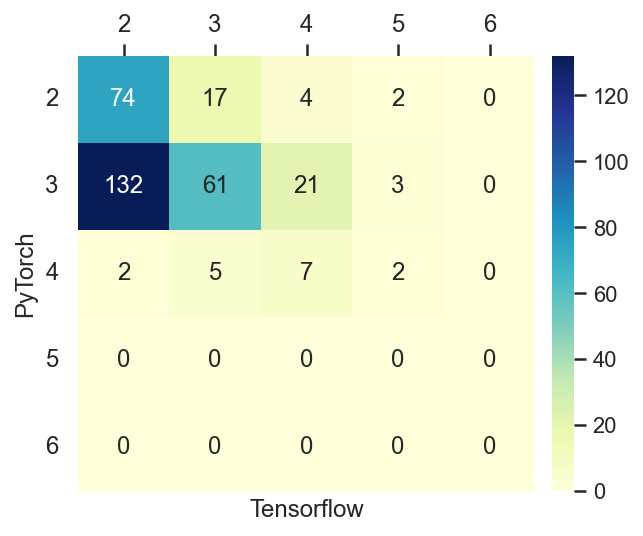

In [15]:
def plot_common_pkg_depth(framework1, framework2):
    data = [[0 for i in range(5)] for j in range(5)]
    pkgs = common_pkgs[f'{framework1}-{framework2}']
    df = pkg_layers[(pkg_layers.package.isin(pkgs)) & (pkg_layers.framework.isin([
        framework1, framework2]))].groupby(['framework', 'package'])['layer'].max()
    for p in pkgs:
        l1, l2 = df.loc[('pytorch', p)], df.loc[('tensorflow', p)]
        data[l1 - 2][l2 - 2] += 1
    x = [2, 3, 4, 5, 6]
    y = [2, 3, 4, 5, 6]
    d = pd.DataFrame(data=data, index=x, columns=y)
    fig, ax = plt.subplots(figsize=(5, 4))
    g = sns.heatmap(d, annot=True, cmap='YlGnBu', fmt='g', cbar_kws={"pad": 0.03}, annot_kws={"size": 12})
    g.set_xlabel('Tensorflow', fontsize=12)
    g.set_ylabel('PyTorch', fontsize=12)
    g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=12, ha='center')
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12)
    g.xaxis.set_ticks_position('top')
    plt.savefig('figures/torch_tf_common_depth.pdf', bbox_inches='tight')

plot_common_pkg_depth('tensorflow', 'pytorch')

In [16]:
tf_common = pkg_layers[(pkg_layers.package.isin(common_pkgs['tensorflow-pytorch'])) & 
                       (pkg_layers.framework == 'tensorflow')]
pt_common = pkg_layers[(pkg_layers.package.isin(common_pkgs['tensorflow-pytorch'])) & 
                       (pkg_layers.framework == 'pytorch')]
_, p1 = mannwhitneyu(tf_layers['down_pkgs'], tf_common['down_pkgs'], alternative='greater')
_, p2 = mannwhitneyu(pt_layers['down_pkgs'], pt_common['down_pkgs'], alternative='greater')
_, p3 = mannwhitneyu(tf_layers['comb_downstream'], tf_common['comb_downstream'], alternative='greater')
_, p4 = mannwhitneyu(pt_layers['comb_downstream'], pt_common['comb_downstream'], alternative='greater')
print(p1, p2, p3, p4)
print(holm_bonferroni([p1, p2, p3, p4]))

0.5050582742143024 0.04763906798066016 0.10287329487480673 0.028998012624682705
[False False False False]


In [27]:
def agg_fn(df):
    return list(df['layer'].values), df['down_pkgs'].iloc[0]
def pp_ms_common():
    return pkg_layers[pkg_layers.package.isin(common_pkgs['pytorch-mindspore']) | 
           pkg_layers.package.isin(common_pkgs['pytorch-paddlepaddle']) | 
           pkg_layers.package.isin(common_pkgs['tensorflow-paddlepaddle'])].groupby([
    'framework', 'package']).agg({'layer': set, 'down_pkgs': np.min, 'comb_downstream': np.min})
pp_ms_common()

layer  down_pkgs  comb_downstream
framework    package                                                
mindspore    READ-mindspore          {2}          0                0
paddlepaddle id-segmenter            {3}          0                0
             idsegmenter          {2, 3}          0                0
             matatron             {2, 3}          0                0
             paddle-tokenizer        {2}          0                1
             paddleocr-sabhi         {2}          0                0
             paddletools             {2}          0                2
             pydp                    {2}          0                0
             qashi                {2, 3}          0                0
             rasa-contrib            {2}          0                1
             sabhi-utils             {2}          4                0
pytorch      READ-mindspore          {3}          0                0
             id-segmenter            {3}          0                0
             idsegmenter       {2, 3, 4}          0                0
             matatron                {3}          0                0
             paddleocr-sabhi   {2, 3, 4}          0                0
             paddletools             {2}          0                2
             qashi             {2, 3, 4}          0                0
             sabhi-utils       {2, 3, 4}          4                0
tensorflow   paddle-tokenizer        {3}          0                1
             pydp                    {2}          0                0
             rasa-contrib      {2, 3, 4}          0                1

In [131]:
def sample_packages():
    samples = pd.DataFrame()
    samples = samples.append([pd.concat([pkg_layers[(pkg_layers['framework'] == 'pytorch') &
                                                 (pkg_layers['layer'] == i)].sample(frac=0.1),
                                        pkg_layers[(pkg_layers['framework'] == 'tensorflow') &
                                                 (pkg_layers['layer'] == i)].sample(frac=0.1)],
                                      ignore_index=True) for i in [2, 3]], ignore_index=True)
    samples = samples.append([pd.concat([pkg_layers[(pkg_layers['framework'] == 'pytorch') &
                                                 (pkg_layers['layer'] == i)],
                                        pkg_layers[(pkg_layers['framework'] == 'tensorflow') &
                                                 (pkg_layers['layer'] == i)]],
                                      ignore_index=True) for i in [4, 5, 6]], ignore_index=True)
    samples = samples.append(pkg_layers[(pkg_layers['framework'].isin(['mxnet', 'paddlepaddle', 'mindspore']))
                                          & (pkg_layers['layer'] > 1)])
    samples[['package', 'layer', 'framework']].to_excel('data/samples.xlsx', index=False)
    return samples

In [159]:
samples = sample_packages()
print(samples.groupby(['layer', 'framework'])['package'].count().unstack().fillna(0).astype(int))

framework  mindspore  mxnet  paddlepaddle  pytorch  tensorflow
layer                                                         
2                  3     62            34      290         234
3                  0     18             6      190          71
4                  0      1             0      161          89
5                  0      0             0       13          11
6                  0      0             0        1           1


In [165]:
def check_old_samples():
    df = pd.read_excel('data/labelled_samples.xlsx')[['name', 'layer', 'framework', 'DR/NDR', 
                                                      'Category', 'Subcategory', 'Comment']]
    df.rename(columns={"name": "package"}, inplace=True)
    new_samples = pd.DataFrame()
    for f in frameworks:
        for i in range(2, 7):
            p1 = set(df[(df.framework == f) & (df.layer == i)]['package'])
            all_df = pkg_layers[(pkg_layers.framework == f) & (pkg_layers.layer == i)][['package', 'layer', 'framework']]
            p2 = set(all_df['package'])
            df = df[~(df['package'].isin(list(p1 -p2)) & (df['layer'] == i))]
            sample_df = df[(df.framework == f) & (df.layer == i)]
            p1 = set(sample_df['package'])
            
            if (f in ['tensorflow', 'pytorch']) and (i in [2, 3]):
                left = round(len(p2) * 0.1) - len(p1)
            else:
                left = len(p2) - len(p1)
            if left <= 0:
                new_samples = new_samples.append(sample_df.head(len(p1)+left))
            if left > 0:
                new_samples = new_samples.append([sample_df, all_df.sample(left)])
    new_samples.to_csv('data/samples.csv', index=False)
    return new_samples
new_samples = check_old_samples()
# new_samples.groupby(['layer', 'framework'])['package'].count().unstack().fillna(0).astype(int)
# print(new_samples.groupby(['layer', 'framework'])['package'].count().unstack().fillna(0).astype(int))
# for p in frameworks:
#     print(f'The number of sampled unique packages in {p} SC: {len(new_samples[new_samples.framework==p]["package"].unique())}')

In [170]:
pkg_layers[(pkg_layers.dependent_number > 0)].groupby(['layer', 'framework'])['package'].count().unstack().fillna(0).astype(int)

framework,mindspore,mxnet,paddlepaddle,pytorch,tensorflow
layer,,,,,
1,1,7,2,1,3
2,0,8,2,380,245
3,0,1,0,243,111
4,0,0,0,24,21
5,0,0,0,3,4


In [171]:
pkg_layers[pkg_layers.package == 'speechbrain']

,package,layer,framework,dependent_number
3707,speechbrain,2,pytorch,2
3708,speechbrain,3,pytorch,2
